In [1]:
import pandas as pd
import os
from tqdm import tqdm
from sportypy.surfaces import MiLBField
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from plotting import plot_animation

In [2]:
base = '/Users/eddie/SMT-Data-Challenge/Combined/'

In [3]:
game_events = pd.read_parquet(base + 'game_events.parquet')
game_info = pd.read_parquet(base + 'game_info.parquet')
team_info = pd.read_parquet(base + 'team_info.parquet')

In [4]:
game_events.sort_values(by=['game_str', 'timestamp', 'event_code'], inplace = True)

In [5]:
df = []

for subdir, dirs, files in os.walk(base + 'ball_pos/'):
    for file in files:
        sub_df = pd.read_parquet(base + 'ball_pos/' + file)
        df.append(sub_df)

ball_pos = pd.concat(df, ignore_index=True)

In [6]:
df = []  

for subdir, dirs, files in os.walk(base + 'player_pos/'):
    for file in tqdm(files, desc='Processing File'):
        sub_df = pd.read_parquet(base + 'player_pos/' + file, engine='fastparquet')
        df.append(sub_df)

player_pos = pd.concat(df, ignore_index=True)

Processing File: 100%|████████████████████████| 338/338 [00:06<00:00, 55.47it/s]
Processing File: 0it [00:00, ?it/s]


# Data Notes:

* Game ##.5 indicates a double header and that is the second game.
* All home teams are within the same farm system.
* Home 4A is highest and 1A is the lowest.
* 1883 season is only half a season and 1884 is a full season.
* Play ids **reset** every game

*player position codes*:
```
{
    1: pitcher
    2: catcher
    3: 1st Baseman
    4: 2nd Baseman
    5: Third basebam
    6: Shortstop
    7: Left Field
    8: Center Field
    9: Right Field
    10: Batter
    11: Runner on first
    12: Runner on second
    13: Runner on third
    255: Ball event with no player (past ball)
}
```
*event codes*:
```
{
    1: Pitch thrown
    2: Ball acquired
    3: Throw for ball in play
    4: Ball hit into play
    5: End of play
    6: Pickoff Throw
    7: Ball acquired: Unkown field position
    8: Throw for ball in play: Unknown field position
    9: Ball deflection
    10: Ball deflection off wall
    11: Home run
    16: Ball bounce
}
```

Question at hand: This year’s dataset will consist of multiple teams within a single farm system. We want you to consider a situation that compares
players, teams, and/or game play at two or more levels.

In [7]:
# Decode the Game Events

PLAYER_POSITION = {
    1: 'P',
    2: 'C',
    3: '1B',
    4: '2B',
    5: '3B',
    6: 'SS',
    7: 'LF',
    8: 'CF',
    9: 'RF',
    10: 'BA', # The batter
    11: 'R1B', # Runner on 1B
    12: 'R2B', # Runner on 2B
    13: 'R3B', # Runner on 3B
    255: 'NA' # Ball event with no player
}

EVENT_CODE = {
    1: 'Pitch',
    2: 'Fielded', # fielded ball
    3: 'Throw', # ball thrown
    4: 'In Play',
    5: 'End of Play',
    6: 'Pickoff',
    7: 'Fielded (Unknown)',
    8: 'Throw (Unknown)',
    9: 'Ball Deflection',
    10: 'Off Wall', # we will note off wall plays are not considered
    11: 'HR',
    16: 'Ball Bounce' # Can bounce multiple times
}


game_events['player_position'] = game_events['player_position'].map(PLAYER_POSITION)
game_events['event_code'] = game_events['event_code'].map(EVENT_CODE)


In [8]:
outfield_positions = ['CF', 'RF', 'LF']

game_events['is_flyout'] = np.where(
    (game_events['player_position'].isin(outfield_positions)) & 
    (game_events['event_code'].isin(['Fielded', 'Ball Deflection'])) & # Want ball deflections as they could be fielding errors but an attempt by the outfielder to get to the ball.
    (game_events['event_code'].shift(1) == 'In Play'), 1, 0
)

In [11]:
# Want to try to get plays where the oufielder almost gets to the ball but not quite makes it
game_events['almost_caught'] = np.where(
    (game_events['player_position'].isin(outfield_positions)) & 
    (game_events['event_code'].isin(['Fielded', 'Ball Deflection'])) & 
    (game_events['event_code'].shift(1) == 'Ball Bounce') & 
    (game_events['event_code'].shift(2) == 'In Play'), 1, 0
)


In [19]:
game_events[game_events['almost_caught'] == 1]

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,is_flyout,almost_caught
56081,1883_001_Vis1AB_Home1A,264,70.0,264,9109565,RF,Fielded,0,1
53082,1883_001_Vis4AB_Home4A,31,6.0,31,772202,RF,Fielded,0,1
53167,1883_001_Vis4AB_Home4A,52,13.0,52,1577702,CF,Fielded,0,1
50820,1883_002_Vis4AB_Home4A,85,21.0,85,2814736,CF,Fielded,0,1
51148,1883_002_Vis4AB_Home4A,171,42.0,171,5616836,LF,Fielded,0,1
...,...,...,...,...,...,...,...,...,...
212534,1884_142_Vis4BE_Home4A,82,25.0,82,2671159,CF,Fielded,0,1
213059,1884_142_Vis4BE_Home4A,226,60.0,227,8164459,LF,Fielded,0,1
213141,1884_142_Vis4BE_Home4A,248,68.0,250,9170209,LF,Fielded,0,1
211150,1884_143_Vis4BE_Home4A,8,2.0,7,182100,RF,Fielded,0,1


In [9]:
game_events[game_events['is_flyout'] == 1]

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,is_flyout
55093,1883_001_Vis1AB_Home1A,2,1.0,2,73273,CF,Fielded,1
55100,1883_001_Vis1AB_Home1A,4,2.0,4,119873,LF,Fielded,1
55281,1883_001_Vis1AB_Home1A,49,12.0,49,1624623,CF,Fielded,1
55291,1883_001_Vis1AB_Home1A,52,13.0,52,1704123,LF,Fielded,1
55350,1883_001_Vis1AB_Home1A,66,16.0,66,2067123,RF,Fielded,1
...,...,...,...,...,...,...,...,...
212043,1884_143_Vis4BE_Home4A,253,62.0,252,8606500,LF,Fielded,1
212102,1884_143_Vis4BE_Home4A,268,67.0,267,9346300,RF,Fielded,1
212127,1884_143_Vis4BE_Home4A,274,69.0,273,9621300,CF,Fielded,1
212154,1884_143_Vis4BE_Home4A,281,71.0,280,9770950,RF,Fielded,1


In [25]:
batter = player_pos[player_pos['player_position'] == 10].copy()

first_field_x = batter.groupby(['game_str', 'play_id'])['field_x'].transform('first')
batter['handedness'] = np.where(first_field_x > 0, 'L', 'R')
handedness_df = batter.groupby(['game_str', 'play_id'])['handedness'].first().reset_index()

player_pos = player_pos.merge(handedness_df, on=['game_str', 'play_id'], how='left')



In [26]:
hit = game_events[game_events['event_code'] == 'In Play'].rename(columns = {'timestamp' : 'start_time'})
# Start time = when the ball is hit into play

fielded = game_events[(game_events['is_flyout'] == 1) | (game_events['almost_caught'] == 1)]

In [27]:
filter_v = pd.merge(fielded, hit, on = ['game_str', 'play_id'], how = 'inner', suffixes = ('', '_hit')).rename(columns={'timestamp' : 'end_time'})



In [28]:
def fill_game_state(row):
    return (
        ('1' if pd.notna(row['first_baserunner']) else '0') +
        ('1' if pd.notna(row['second_baserunner']) else '0') +
        ('1' if pd.notna(row['third_baserunner']) else '0')
    )

In [29]:
filter_v = filter_v.iloc[:,:-3]
filter_v.drop(['at_bat_hit', 'play_per_game_hit', 'is_flyout'], axis = 1, inplace=True)

player_ids = game_info[['game_str', 'play_per_game', 'inning', 'at_bat', 'top_bottom', 'left_field', 'center_field', 'right_field']]
player_ids['game_state'] = (game_info[['first_baserunner', 'second_baserunner', 'third_baserunner']]
                            .apply(fill_game_state, axis = 1))

filter_v = pd.merge(filter_v, player_ids, on = ['game_str', 'at_bat', 'play_per_game'], how = 'inner')

filter_v[['left_field', 'center_field', 'right_field']] = filter_v.groupby(['game_str', 'top_bottom'])[['left_field', 'center_field', 'right_field']].ffill()

# Filling in player ids
filter_v['player_id'] = np.where(
    filter_v['player_position'] == 'LF', filter_v['left_field'],
    np.where(
        filter_v['player_position'] == 'CF', filter_v['center_field'],
        filter_v['right_field']
    )
)

filter_v.drop(columns=['top_bottom', 'left_field', 'center_field', 'right_field'], inplace=True)

/var/folders/0m/p03jcv9j4td3thddmd99m0300000gp/T/ipykernel_99286/3485596657.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_ids['game_state'] = (game_info[['first_baserunner', 'second_baserunner', 'third_baserunner']]


In [30]:
filter_v

,game_str,play_id,at_bat,play_per_game,end_time,player_position,event_code,almost_caught,start_time,player_position_hit,inning,game_state,player_id
0,1883_001_Vis1AB_Home1A,2,1.0,2,73273,CF,Fielded,0,67773,BA,1,000,594.0
1,1883_001_Vis1AB_Home1A,4,2.0,4,119873,LF,Fielded,0,114723,BA,1,000,492.0
2,1883_001_Vis1AB_Home1A,49,12.0,49,1624623,CF,Fielded,0,1621073,BA,2,000,NaN
3,1883_001_Vis1AB_Home1A,52,13.0,52,1704123,LF,Fielded,0,1700073,BA,2,000,NaN
4,1883_001_Vis1AB_Home1A,66,16.0,66,2067123,RF,Fielded,0,2062623,BA,3,000,537.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4794,1884_143_Vis4BE_Home4A,253,62.0,252,8606500,LF,Fielded,0,8602800,BA,7,110,2188.0
4795,1884_143_Vis4BE_Home4A,268,67.0,267,9346300,RF,Fielded,0,9343100,BA,8,100,502.0
4796,1884_143_Vis4BE_Home4A,274,69.0,273,9621300,CF,Fielded,0,9616000,BA,8,000,8801.0
4797,1884_143_Vis4BE_Home4A,281,71.0,280,9770950,RF,Fielded,0,9765150,BA,8,000,6466.0


In [31]:
outfielders = player_pos[player_pos['player_position'].isin([7, 8, 9])].copy()
outfielders['player_position'] = outfielders['player_position'].map(PLAYER_POSITION)

In [32]:
player_pos_out = pd.merge(filter_v, outfielders, left_on=['game_str', 'play_id', 'start_time', 'player_position'], right_on = ['game_str', 'play_id', 'timestamp', 'player_position'], how='left').drop('timestamp', axis = 1)



In [33]:
ball_pos_out = pd.merge(filter_v, ball_pos, left_on=['game_str', 'play_id', 'end_time'], right_on = ['game_str', 'play_id', 'timestamp'], how='left').drop('timestamp', axis = 1)
ball_pos_out = ball_pos_out[['game_str', 'play_id', 'at_bat', 'ball_position_x', 'ball_position_y', 'ball_position_z']]


# Removed about 36 rows that were bad data
final = pd.merge(player_pos_out, ball_pos_out, on = ['game_str', 'play_id', 'at_bat'], how = 'left').dropna(subset = ['field_x', 'ball_position_x'])



In [34]:
# Find maximum player location
max_out_location = outfielders.loc[outfielders.groupby(['game_str', 'play_id', 'player_position'])['timestamp'].idxmax(), 
                ['game_str', 'play_id', 'player_position', 'field_x', 'field_y']].rename(columns={
    'field_x': 'field_end_x', 'field_y': 'field_end_y'})



In [35]:
def derive_hitting_metrics(df):
    dx = df.groupby(['game_str', 'play_id'])['ball_position_x'].diff() 
    dy = df.groupby(['game_str', 'play_id'])['ball_position_y'].diff()
    dz = df.groupby(['game_str', 'play_id'])['ball_position_z'].diff()
    
    # Timestamp diff
    dt = df.groupby(['game_str', 'play_id'])['timestamp'].diff()
    
    # velocity vectors
    vx = dx / dt
    vy = dy / dt
    vz = dz / dt
    
    # Exit velocity = magnitude of the displacement vectors
    df['exit_velocity'] = (np.sqrt(vx**2 + vy**2 + vz**2)) * 3600000 / 5280 # miles per hour
    # Inverse tan of the perpendicular (z coordinate) / base (distance between x and y vectors)
    # (-) z coordinates so take the absolute value of them.
    df['launch_angle'] = np.degrees(np.arctan2(abs(vz), np.sqrt(vx**2 + vy**2)))
    
    return df
    
    

In [36]:
# Find the timestamps where the ball makes contact then derive the launch angle and exit velo
# First I need to find the timestamp of the hit then derive the difference of the next two timestamps.
# In filter_v start time = what I want. Just need the next 2

contact_df = ball_pos.merge(filter_v, left_on = ['game_str', 'play_id'], right_on = ['game_str', 'play_id'], how = 'inner')
contact_df = contact_df[(contact_df['timestamp'] >= contact_df['start_time']) &
                       (contact_df['end_time'] >= contact_df['timestamp'])]
contact_df = derive_hitting_metrics(contact_df)

# 2nd to 5th observation to eliminate possible error from initial hit.
contact_df = contact_df.groupby(['game_str', 'play_id'])[['exit_velocity', 'launch_angle']].apply(lambda x: x.iloc[1:5].mean()).reset_index()



In [37]:
final = pd.merge(final, contact_df, on = ['game_str', 'play_id'], how = 'left')
final = pd.merge(final, max_out_location, on = ['game_str', 'play_id', 'player_position'], how = 'left')

In [38]:
# This filters plays where an outfielder fields the ball, a total of 4,064 observations. 

final

,game_str,play_id,at_bat,play_per_game,end_time,player_position,event_code,almost_caught,start_time,player_position_hit,...,field_x,field_y,handedness,ball_position_x,ball_position_y,ball_position_z,exit_velocity,launch_angle,field_end_x,field_end_y
0,1883_001_Vis1AB_Home1A,2,1.0,2,73273,CF,Fielded,0,67773,BA,...,-5.6358,308.5794,R,-16.98135,329.4720,4.787370,81.734102,36.822336,-18.0411,328.0791
1,1883_001_Vis1AB_Home1A,4,2.0,4,119873,LF,Fielded,0,114723,BA,...,-125.0325,241.4478,L,-133.04100,182.3649,4.718250,75.201857,47.196069,-131.9796,178.2810
2,1883_001_Vis1AB_Home1A,49,12.0,49,1624623,CF,Fielded,0,1621073,BA,...,-1.0332,311.2104,L,29.13606,260.8020,2.199318,67.738023,23.938940,30.5283,244.6044
3,1883_001_Vis1AB_Home1A,52,13.0,52,1704123,LF,Fielded,0,1700073,BA,...,-131.7357,266.6529,R,-89.36070,302.4690,3.871440,96.605867,21.745768,-86.8119,308.9538
4,1883_001_Vis1AB_Home1A,66,16.0,66,2067123,RF,Fielded,0,2062623,BA,...,126.2733,231.2652,R,100.18980,313.6980,6.418260,100.555112,25.267411,96.4707,330.6606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4753,1884_142_Vis4BE_Home4A,227,61.0,228,8212309,RF,Fielded,0,8206859,BA,...,131.9016,259.6098,R,125.81310,314.5740,5.314890,100.107820,31.172241,132.9711,323.6319
4754,1884_142_Vis4BE_Home4A,232,63.0,234,8477309,CF,Fielded,0,8471509,BA,...,25.4760,304.4340,R,75.99360,300.5610,5.442150,101.744036,37.217006,79.8729,300.5508
4755,1884_142_Vis4BE_Home4A,248,68.0,250,9170209,LF,Fielded,1,9167159,BA,...,-131.0262,254.2587,R,-93.63960,255.4401,5.172240,101.502492,18.835599,-87.9705,252.0558
4756,1884_142_Vis4BE_Home4A,257,71.0,259,9662709,LF,Fielded,0,9659159,BA,...,-140.7099,228.7614,L,-179.86470,219.5319,6.831900,68.887954,23.794789,-189.3228,222.6675


In [39]:
def plot_heatmap(df):
    field = MiLBField()

    plt.figure(figsize=(12, 10))

    field.draw()

    positions = ['LF', 'CF', 'RF']

    for position in positions:
        position_data = df[df['player_position'] == position]
        sns.kdeplot(
            x=position_data['ball_position_x'],
            y=position_data['ball_position_y'],
            cmap='magma',
            alpha=0.6,
            fill = True,
            levels = 8,
            ax=plt.gca()
        )

        plt.text(position_data.field_x.mean(), position_data.field_y.mean(), 
                 position, fontsize=12, ha='center', color='black', fontweight = 'bold')

    plt.title('Heatmap of Flyball Attempts by Outfielders', c = 'w')

    plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

<Figure size 1200x1000 with 0 Axes>

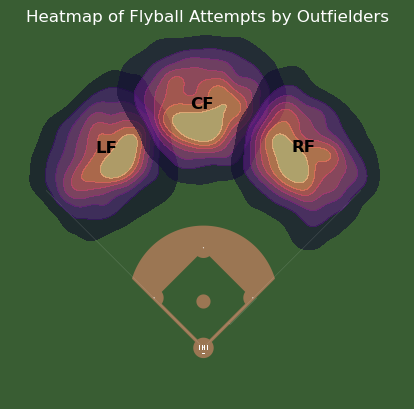

In [40]:
plot_heatmap(final)

In [244]:
# 94,499 events

(4064 / 94499) * 100
# About 4% of our plays are flyouts or dropped fly balls.

# CF	1595
# LF	1264
# RF	1205 Play totals <–

4.300574609255124

# Steps to Take

Identify how to make a range map. Essentially, it will be for **any** fly ball so I will need to find where a player is in their starting position then where they end up on the field. You draw a line with opacity to it and it should output something like this:
[Outfield](https://grantland.com/the-triangle/2014-mlb-playoffs-exploiting-kansas-city-royals-ultimate-outfield-jarrod-dyson-alex-gordon-lorenzo-cain/)
This is going to be used for route efficiency. 


Here's what the model will be initially:
* Input features like hang time, angle to the ball, etc.
* Outputs the expected time for a player to reach the ball. 
* Compare it throughout the different leagues to see what players are getting to the ball.
* Once I have it, I could make a hexbin plot of where players are strong suited to where they may get to the ball from the outfield. 
* *Maybe* normalize it?

TODO:
1. I may add a beizer curve as an input feature to see if the curvier the route, the more distance required to 
    get to the ball which I'm not sure. [Beizer curve guess](https://javascript.info/bezier-curve)
2. Fix my approach angle to make it normalized for each outfielder. I may also want to compare to the actual distance to the ball.


In [41]:
def linear_points(df):
    def fill_na_in_group(group, field_x, field_y):
        """Yuck, sorry about this code but it was the most effective way that I know 
           that doesn't require too much computation for a linear line.
        """
        group.loc[:, 'linear_x'] = np.nan
        group.loc[:, 'linear_y'] = np.nan
        first = group.index[0] # I need the actual indices which kind of suck iloc won't do the trick either.
        last = group.index[-1]
        group.loc[first, 'linear_x'] = group.loc[first, field_x]
        group.loc[last, 'linear_x'] = group.loc[last, field_x]
        
        group.loc[first, 'linear_y'] = group.loc[first, field_y]
        group.loc[last, 'linear_y'] = group.loc[last, field_y]
        
        group['linear_x'] = group['linear_x'].interpolate(method='linear')
        group['linear_y'] = group['linear_y'].interpolate(method='linear')
        return group
    
    return (df.groupby(['game_str', 'play_id']).apply(fill_na_in_group, 'field_x_int', 'field_y_int')
            .reset_index(drop = True))


In [42]:
actual_routes = pd.merge(final, outfielders, on = ['game_str', 'play_id', 'player_position'], how = 'left', suffixes = ('', '_int'))
actual_routes = linear_points(actual_routes)

values = []
for (game_str, play_id), play in tqdm(actual_routes.groupby(['game_str', 'play_id']), desc = 'Extracting distance'):
    play['x_diff'] = play['field_x_int'].diff().fillna(0)
    play['y_diff'] = play['field_y_int'].diff().fillna(0)
    
    play['timestamp'] = play['timestamp'] / 1000
    
    play['time_diff'] = play['timestamp'].diff().fillna(0)
    
    play['stepwise_diff'] = np.sqrt(play['x_diff']**2 + play['y_diff'] ** 2)
    
    play['speed'] = play['stepwise_diff'] / play['time_diff']
    
    distance = np.sum(play['stepwise_diff'])
    
    max_speed = play['speed'].max()
    mean_speed =  play['speed'].mean()
    
    
    # Figure this out later, first compute the maximum distance difference on perpendicular plane.
    play['perp_distance'] = abs(play['linear_y'] - play['field_y_int']) # Only really care about the max distance between y values for perpendicular.
    p1_x, p1_y = play.loc[play['perp_distance'].idxmax(), ['field_x_int', 'field_y_int']] # Control points.
    
#     initial_angle = np.degrees(np.arctan2(play['y_diff'].iloc[1:4].mean(), play['x_diff'].iloc[1:4].mean())) # Compute initial angle
#     # adjust for the different fielders
#     # Try radial coordiantes related to y. Define y prime and x prime. Do from Home Plate.
#     if play['player_position'].iloc[0] == 'LF':
#         initial_angle = (270 - initial_angle) % 360
#     elif play['player_position'].iloc[0] == 'RF':
#         initial_angle = (90 - initial_angle) % 360
    
    values.append({'game_str': game_str, 'play_id': play_id,
                      'actual_distance': distance, 'max_speed': max_speed, 'mean_speed': mean_speed,
                    'p1_x' : p1_x, 'p1_y' : p1_y}) # # 'initial_angle' : initial_angle, 



Extracting distance: 100%|████████████████| 4755/4755 [00:04<00:00, 1069.83it/s]


Text(0.5, 1.0, 'Straight line route vs. actual route')

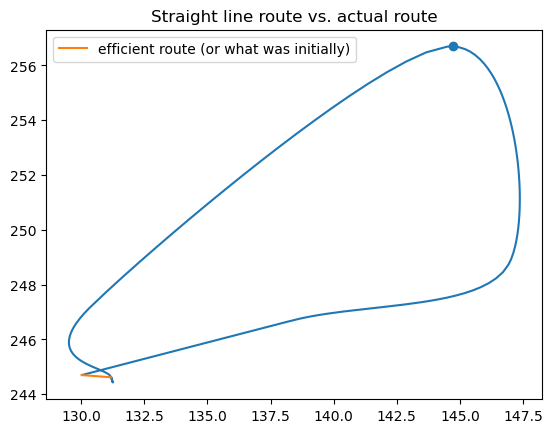

In [86]:
game = '1884_035_Vis1AO_Home1A'
play_id = 185
plot_test = actual_routes.query(f"game_str == '{game}' & play_id == {play_id}")
coords = final.query(f"game_str == '{game}' & play_id == {play_id}")
plt.plot(plot_test['field_x_int'], plot_test['field_y_int'])
plt.plot(plot_test['linear_x'], plot_test['linear_y'], label = 'efficient route (or what was initially)')
plt.scatter(coords['p1_x'], coords['p1_y'])
plt.legend(loc= 'best')
plt.title('Straight line route vs. actual route')

In [44]:
derived_values = pd.DataFrame(values)
final = pd.merge(final, derived_values, on = ['game_str', 'play_id'], how = 'left')

In [45]:
final['straight_line'] = np.sqrt((final['field_end_x'] - final['field_x']) ** 2 + 
                                (final['field_end_y'] - final['field_y']) ** 2)


final['route_efficiency'] = final['straight_line'] / final['actual_distance']

final['max_player_speed'] = final.groupby('player_id')['mean_speed'].transform('max')

final['max_player_speed'].fillna(12.877761, inplace = True) # gonna fill in with the median speed

final['actual_time'] = (final['end_time'] - final['start_time']) / 1000

In [46]:
final.isna().sum()

game_str                 0
play_id                  0
at_bat                 185
play_per_game            0
end_time                 0
player_position          0
event_code               0
almost_caught            0
start_time               0
player_position_hit      0
inning                   0
game_state               0
player_id              547
field_x                  0
field_y                  0
handedness               0
ball_position_x          0
ball_position_y          0
ball_position_z          0
exit_velocity            0
launch_angle             0
field_end_x              0
field_end_y              0
actual_distance          0
max_speed                0
mean_speed               0
p1_x                     0
p1_y                     0
straight_line            0
route_efficiency         0
max_player_speed         0
actual_time              0
dtype: int64

In [47]:
final.query('launch_angle < 10')['exit_velocity']

17      119.629735
27       47.731857
71      108.424535
77      113.777286
133      84.888331
151      95.365871
412     101.658573
422      84.665667
436      84.247456
499     127.963494
501      99.017922
502     116.540670
605     119.079061
609     108.504705
632      87.747483
694     103.983098
703      93.416892
729     117.966036
745      81.433872
892      98.795837
1047     91.169836
1182    119.442193
1359    102.926571
1505    100.859994
1732     77.607628
1773    115.129833
1932    104.339948
2051    119.531422
2078    100.082263
2113    114.527070
2268    119.787776
2374     84.069441
2378     51.544080
2630     56.598664
2730    140.916678
2868    116.550629
2970    113.489071
3181     99.934640
3304    115.106135
3329    119.659862
3466    100.786155
3486     88.375441
3616     77.403370
3758    116.356517
3785    116.749661
3954     71.756626
4114    113.423120
4216    111.109544
4228     91.999269
4420     78.738375
4521     79.827758
4701    113.593810
4717    122.

<Axes: >

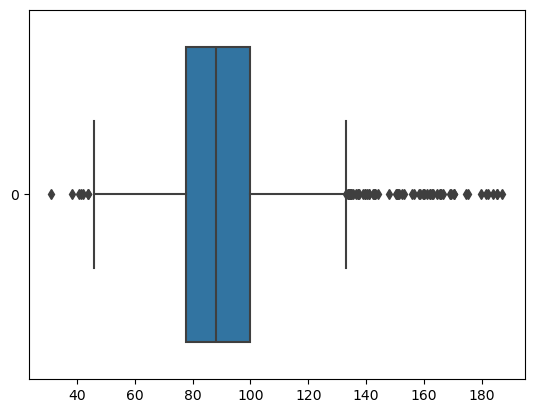

In [48]:
sns.boxplot(final['exit_velocity'], orient='h')

<Axes: >

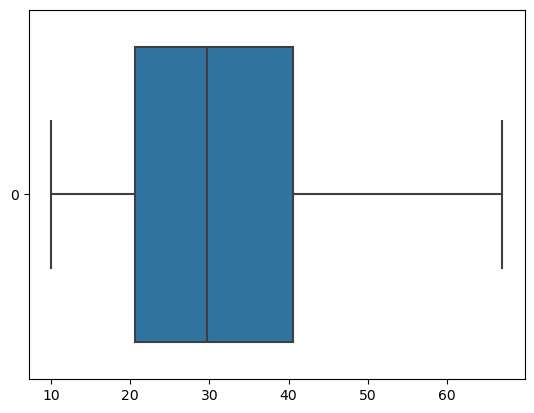

In [49]:
sns.boxplot(final.query('launch_angle > 10')['launch_angle'], orient='h')

In [50]:
# Gonna remove bad data for launch angle
# Reason being this:

# As a guideline, here are the Launch Angles for different types of contact:

# Ground ball: Less than 10 degrees
# Line drive: 10-25 degrees
# Fly ball: 25-50 degrees
# Pop up: Greater than 50 degrees


# Grabbed the 2nd to 5th timestamp window 
# There are 10 launch angle positions that are not correct. Bad data?

final = final.query('launch_angle > 10')

In [51]:
final['league'] = final['game_str'].apply(lambda x: x.split('_')[-1])
final['handedness_encode'] = final['handedness'].map({'L' : 0, 'R' : 1}) # Batter handedness

In [35]:
final.groupby(['player_position', 'league'])['initial_angle'].median()

KeyError: 'Column not found: initial_angle'

In [206]:
final.groupby(['player_position', 'game_state'])['initial_angle'].median().reset_index()

,player_position,game_state,initial_angle
0,CF,000,-66.454346
1,CF,001,-50.239587
2,CF,010,-71.010499
3,CF,011,-82.865790
4,CF,100,-74.843919
5,CF,101,-91.773169
6,CF,110,-70.030710
7,CF,111,-74.951684
8,LF,000,222.600517
9,LF,001,298.945170


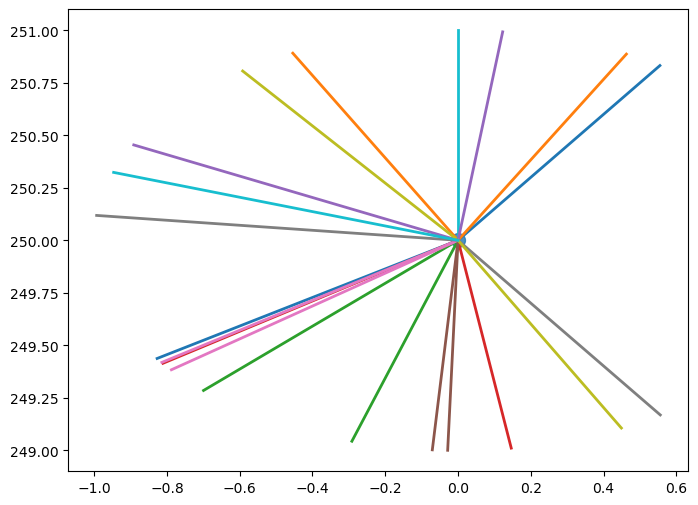

In [211]:
l = final[final['player_position'] == 'CF'].iloc[:20]
plt.figure(figsize=(8, 6))
plt.scatter(0, 250, s=100, alpha=0.8)
for index, row in l.iterrows():
    start_x = 0
    start_y = 250
    angle_rad = np.radians(row['initial_angle'])
    end_x = start_x + np.cos(angle_rad)
    end_y = start_y + np.sin(angle_rad)
    plt.plot([start_x, end_x], [start_y, end_y], linewidth=2)

/var/folders/0m/p03jcv9j4td3thddmd99m0300000gp/T/ipykernel_65438/3257179822.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Set1', len(unique_states))


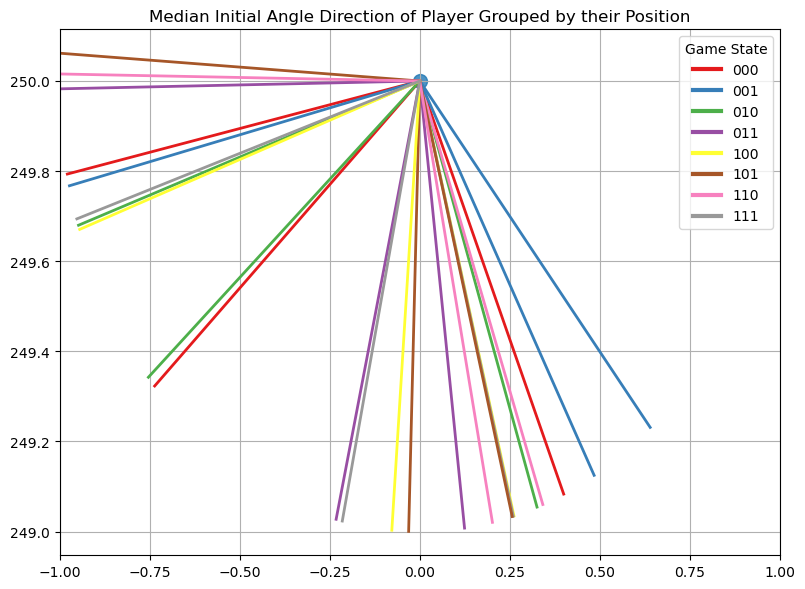

In [205]:
pos_angles = final.groupby(['player_position', 'game_state'])['initial_angle'].median().reset_index()
unique_states = pos_angles['game_state'].unique()
cmap = plt.cm.get_cmap('Set1', len(unique_states)) 


# Keep in mind positive numbers mean moving to their right, while negative is to their left.

plt.figure(figsize=(8, 6))
plt.scatter(0, 250, s=100, alpha=0.8)
for index, row in pos_angles.iterrows():
    start_x = 0
    start_y = 250
    angle_rad = np.radians(row['initial_angle'])
    end_x = start_x + np.cos(angle_rad)
    end_y = start_y + np.sin(angle_rad)
    color = cmap(np.where(unique_states == row['game_state'])[0][0])
    plt.plot([start_x, end_x], [start_y, end_y], color=color, linewidth=2, label=row['game_state'])
plt.title('Median Initial Angle Direction of Player Grouped by their Position')
plt.grid(True)
plt.tight_layout()
handles = [plt.Line2D([0, 1], [0, 0], color=cmap(i), linewidth=3) for i in range(len(unique_states))]
plt.legend(handles, unique_states, title='Game State', loc='best')
plt.xlim(-1, 1)
plt.show()

In [52]:
final.groupby(['league', 'game_state'])['route_efficiency'].mean()

league  game_state
Home1A  000           0.824554
        001           0.753319
        010           0.786097
        011           0.753245
        100           0.764388
        101           0.757730
        110           0.775543
        111           0.775274
Home2A  000           0.828829
        001           0.748141
        010           0.740351
        011           0.741172
        100           0.748019
        101           0.756875
        110           0.743958
        111           0.735221
Home3A  000           0.836324
        001           0.725788
        010           0.774353
        011           0.819559
        100           0.773563
        101           0.755209
        110           0.789295
        111           0.816042
Home4A  000           0.820935
        001           0.740804
        010           0.730460
        011           0.714227
        100           0.744819
        101           0.747664
        110           0.754723
        111         

In [53]:
# This is good that there is a balance amongst the league numbers so it won't overfit to a particular league... hopefully.

final.league.value_counts()

league
Home1A    1251
Home4A    1244
Home3A    1147
Home2A    1061
Name: count, dtype: int64

In [54]:
final.player_position.value_counts()

player_position
CF    1834
LF    1458
RF    1411
Name: count, dtype: int64

In [55]:
final.player_id.value_counts().head(10)

player_id
651.0    142
495.0    140
475.0    140
963.0    132
492.0    128
892.0    109
435.0     99
460.0     98
537.0     96
975.0     85
Name: count, dtype: int64

In [72]:
final

,game_str,play_id,at_bat,play_per_game,end_time,player_position,event_code,almost_caught,start_time,player_position_hit,...,max_speed,mean_speed,p1_x,p1_y,straight_line,route_efficiency,max_player_speed,actual_time,league,handedness_encode
0,1883_001_Vis1AB_Home1A,2,1.0,2,73273,CF,Fielded,0,67773,BA,...,24.000819,6.840812,-11.2935,336.8631,23.111248,0.553842,18.968681,5.50,Home1A,1
1,1883_001_Vis1AB_Home1A,4,2.0,4,119873,LF,Fielded,0,114723,BA,...,17.121898,11.944920,-135.0942,236.0112,63.547674,0.879348,18.278859,5.15,Home1A,0
2,1883_001_Vis1AB_Home1A,49,12.0,49,1624623,CF,Fielded,0,1621073,BA,...,37.684892,15.416904,12.0057,307.9278,73.705410,0.831447,12.877761,3.55,Home1A,0
3,1883_001_Vis1AB_Home1A,52,13.0,52,1704123,LF,Fielded,0,1700073,BA,...,19.697577,11.857446,-132.0213,267.6108,61.705056,0.963687,12.877761,4.05,Home1A,1
4,1883_001_Vis1AB_Home1A,66,16.0,66,2067123,RF,Fielded,0,2062623,BA,...,27.926950,18.625452,122.1582,239.5527,103.767242,0.986064,18.625452,4.50,Home1A,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4752,1884_142_Vis4BE_Home4A,226,60.0,227,8164459,LF,Fielded,1,8160659,BA,...,44.665356,10.862429,-72.5286,231.5289,76.262876,0.883119,12.154987,3.80,Home4A,0
4753,1884_142_Vis4BE_Home4A,227,61.0,228,8212309,RF,Fielded,0,8206859,BA,...,19.617373,10.775709,129.6549,263.3454,64.031032,0.921266,16.983263,5.45,Home4A,1
4754,1884_142_Vis4BE_Home4A,232,63.0,234,8477309,CF,Fielded,0,8471509,BA,...,13.726998,8.445204,41.7330,307.4571,54.535328,0.971060,17.721751,5.80,Home4A,1
4755,1884_142_Vis4BE_Home4A,248,68.0,250,9170209,LF,Fielded,1,9167159,BA,...,27.866606,6.473715,-119.8737,256.3671,43.112018,0.944617,12.154987,3.05,Home4A,1


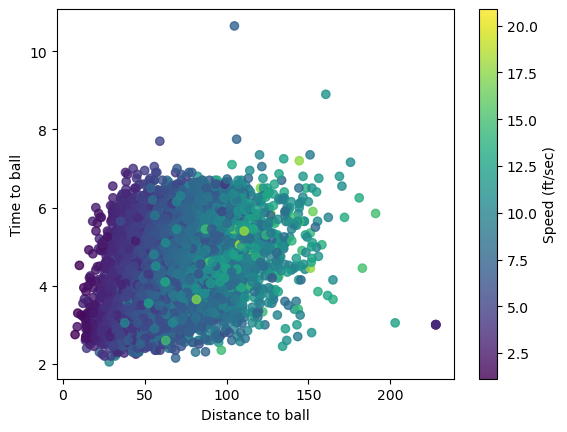

In [74]:
plt.scatter(final['actual_distance'], final['actual_time'], c= final['mean_speed'], alpha = 0.8)
plt.colorbar(label='Speed (ft/sec)')
plt.xlabel('Distance to ball')
plt.ylabel('Time to ball')
plt.show()

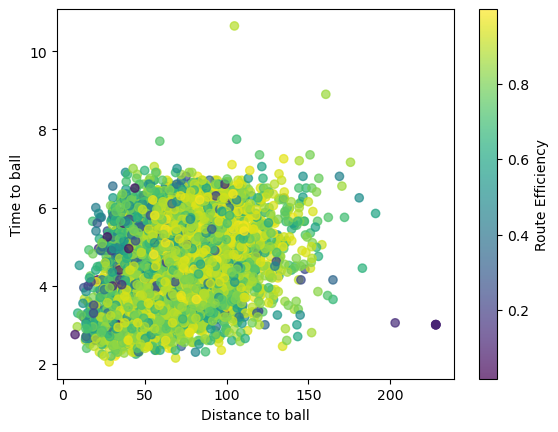

In [75]:
plt.scatter(final['actual_distance'], final['actual_time'], c= final['route_efficiency'], alpha = 0.7)
plt.colorbar(label='Route Efficiency')
plt.xlabel('Distance to ball')
plt.ylabel('Time to ball')
plt.show()

In [76]:
final.to_csv('./Clean/flyball_data.csv', index = False)

In [2]:
help(plot_animation)

Help on function plot_animation in module plotting:

plot_animation(player_position_df: pandas.core.frame.DataFrame, ball_position_df: pandas.core.frame.DataFrame, play_id: int = 1, save_gif: bool = False) -> IPython.core.display.HTML
    A function that plots field animations for a particular instance of a game.
    Example usage:
    
    ```
    player_pos = pd.read_parquet('./Combined/player_pos/1884_110_Vis2AR_Home2A.parquet')
    ball_pos = pd.read_parquet('./Combined/ball_pos/1884_110_Vis2AR_Home2A.parquet')
    
    plot_animation(player_pos, ball_pos, play_id = 30, save_gif = True)
    ```
    
    Params:
        player_position_df: A Data Frame for the player position coordinates on a field.
        ball_position_df: A Data Frame for the ball position coordiantes on a field.
        play_id: A integer field that denotes the play id you want to visualize. Defaults to 1.
        save_gif: A boolean that when set to true saves the animation to a gif. 
                  Defaults

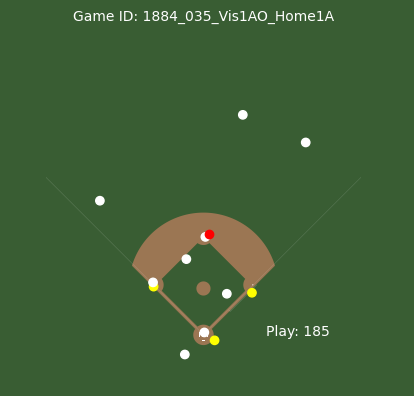

In [87]:
pp = pd.read_parquet('./Combined/player_pos/1884_035_Vis1AO_Home1A.parquet')
bp = pd.read_parquet('./Combined/ball_pos/1884_035_Vis1AO_Home1A.parquet')

plot_animation(pp, bp, play_id = 185)

In [158]:
unique_teams = team_info.groupby('player_id')['home_team'].nunique().sort_values(ascending = False).reset_index()


positions = game_info.iloc[:, 7:16]

players = {}
for position in positions.columns:
    players[position] = set(positions[position].dropna())
    
    
for position, ids in players.items():
    for id_ in ids:
        team_indices = unique_teams.index[unique_teams['player_id'] == id_].tolist()
        unique_teams.loc[team_indices, 'position'] = position
        
unique_teams[unique_teams['home_team'] > 1]['position'].value_counts()

position
pitcher         42
right_field     10
shortstop        7
catcher          6
center_field     5
left_field       4
third_base       4
first_base       3
second_base      2
Name: count, dtype: int64

In [165]:
unique_teams['position'].value_counts()

position
pitcher         110
right_field      27
catcher          14
shortstop        13
first_base       10
center_field     10
left_field        8
third_base        8
second_base       2
nan               1
Name: count, dtype: int64